<img src="imgs/dh_logo.png" align="right" width="50%">

# Exemplo Prático - Heart Disease

<br>
<br>
<img src="heart.gif" align="center" width="35%">
<br>
<br>

## Conjunto de dados

-----------

#### Usaremos o `dataset` [Heart statlog](https://datahub.io/machine-learning/heart-statlog#resource-heart-statlog_zip.), com informações médicas sobre pacientes. Existem $13$ colunas no conjunto de dados, que são descritas abaixo:

- `'slope'`: slope_of_peak_exercise_st_segment (type: int): a inclinação do segmento ST do pico do exercício, uma eletrocardiografia lida indicando a qualidade do fluxo sanguíneo no coração

- `'thal'` (tipo: categórico): resultados do teste de estresse com tálio que mede o fluxo sanguíneo para o coração, com possíveis valores normal, defeito fixo, defeito reversível

- `'resting_blood_pressure'` (type: int): pressão arterial em repouso

- `'chest: chest_pain_type'` (type: int): tipo de dor no peito (4 valores)

- `'num_major_vessels'` (type: int): número de vasos principais (0-3) coloridos por flourosopy

- `'fasting_blood_sugar_gt_120_mg_per_dl'` (tipo: binário): açúcar no sangue em jejum> 120 mg / dl

- `'resting_electrocardiographic_results'`: resting_ekg_results (type: int): resultados eletrocardiográficos de repouso (valores 0,1,2)

- `'serum_cholestoral'`: soro_colesterol_mg_por_dl (tipo: int): colesterol sérico em mg / dl

- `'oldpeak'`: oldpeak_eq_st_depression (tipo: float): oldpeak = depressão do ST induzida pelo exercício em relação ao repouso, uma medida de anormalidade nos eletrocardiogramas

- `'sex'`: sexo (tipo: binário): 0: feminino, 1: masculino

- `'age'`: idade (tipo: int): idade em anos

- `'maximum_heart_rate_achieved'` (type: int): frequência cardíaca máxima atingida (batimentos por minuto)

- `'exercise_induced_angina'` (tipo: binário): dor no peito induzida por exercício (0: Falso, 1: Verdadeiro)


#### Nosso objetivo é prever a classe binária `'class'`, que representa se um paciente tem ou não uma doença cardíaca:

    - 0 representa nenhuma doença cardíaca presente
    - 1 representa doença cardíaca presente

#### Importando as bibliotecas

In [34]:
from pandas import set_option
%matplotlib inline
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# for preprocessing the data
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import log_loss

# the model
from sklearn.linear_model import LogisticRegression

# for combining the preprocess with model training
from sklearn.pipeline import Pipeline

# for optimizing parameters of the pipeline
from sklearn.model_selection import GridSearchCV

import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

#### Lendo e verificando os dados

In [35]:
df = pd.read_csv("heart-statlog.csv", 
                 delimiter = ','
                )
df.head()
#df.columns

,age,sex,chest,resting_blood_pressure,serum_cholestoral,fasting_blood_sugar,resting_electrocardiographic_results,maximum_heart_rate_achieved,exercise_induced_angina,oldpeak,slope,number_of_major_vessels,thal,class
0,70,1,4,130,322,0,2,109,0,2.4,2,3,3,present
1,67,0,3,115,564,0,2,160,0,1.6,2,0,7,absent
2,57,1,2,124,261,0,0,141,0,0.3,1,0,7,present
3,64,1,4,128,263,0,0,105,1,0.2,2,1,7,absent
4,74,0,2,120,269,0,2,121,1,0.2,1,1,3,absent


#### verificando as informações básicas do `DataFrame`.

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 270 entries, 0 to 269
Data columns (total 14 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   age                                   270 non-null    int64  
 1   sex                                   270 non-null    int64  
 2   chest                                 270 non-null    int64  
 3   resting_blood_pressure                270 non-null    int64  
 4   serum_cholestoral                     270 non-null    int64  
 5   fasting_blood_sugar                   270 non-null    int64  
 6   resting_electrocardiographic_results  270 non-null    int64  
 7   maximum_heart_rate_achieved           270 non-null    int64  
 8   exercise_induced_angina               270 non-null    int64  
 9   oldpeak                               270 non-null    float64
 10  slope                                 270 non-null    int64  
 11  number_of_major_ves

#### Verificando a existência de dados nulos com a biblioteca [`missingno`](https://pypi.org/project/missingno/).

In [37]:
#!pip3 install missingno --user

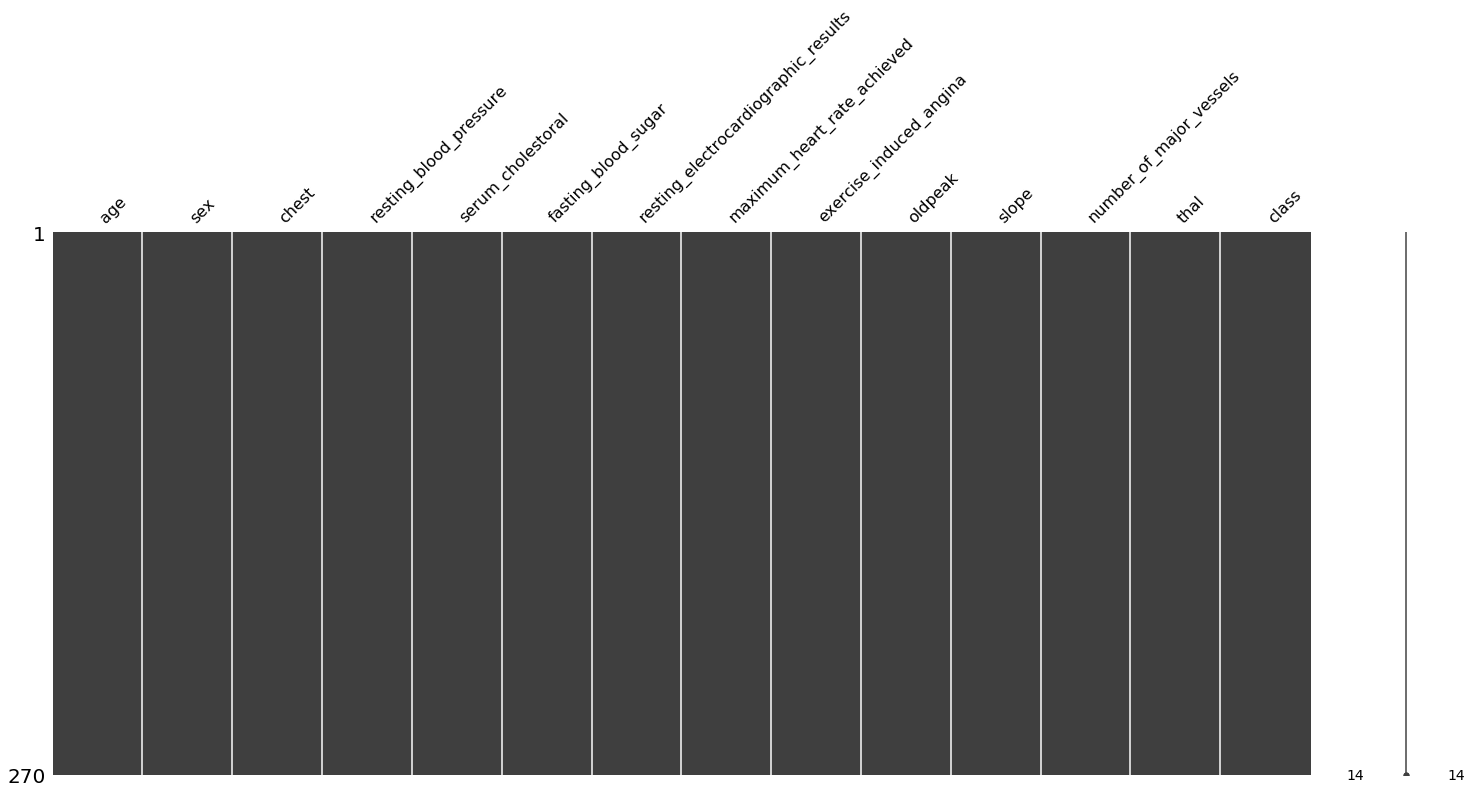

In [38]:
import missingno as msno
%matplotlib inline
msno.matrix(df);

#### Substituindo os valores `absent: 0`, `present: 1` da variável `'class'`.

In [39]:
df.replace({'absent': 0, 'present': 1}, 
           inplace = True
          )
df.head()

,age,sex,chest,resting_blood_pressure,serum_cholestoral,fasting_blood_sugar,resting_electrocardiographic_results,maximum_heart_rate_achieved,exercise_induced_angina,oldpeak,slope,number_of_major_vessels,thal,class
0,70,1,4,130,322,0,2,109,0,2.4,2,3,3,1
1,67,0,3,115,564,0,2,160,0,1.6,2,0,7,0
2,57,1,2,124,261,0,0,141,0,0.3,1,0,7,1
3,64,1,4,128,263,0,0,105,1,0.2,2,1,7,0
4,74,0,2,120,269,0,2,121,1,0.2,1,1,3,0


#### Contando os dados para a existência ou não de condição cardíaca e renomeamos a coluna `'class'`.

In [40]:
df['class'].value_counts()

0    150
1    120
Name: class, dtype: int64

In [41]:
df.rename(columns = {"class": "class"}, 
          inplace = True
         )

#### Separação dos dados em treino e teste, tomamos uma amostra.

In [42]:
# 180 primeiras linhas
train = df.iloc[ : 180, : ] 
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180 entries, 0 to 179
Data columns (total 14 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   age                                   180 non-null    int64  
 1   sex                                   180 non-null    int64  
 2   chest                                 180 non-null    int64  
 3   resting_blood_pressure                180 non-null    int64  
 4   serum_cholestoral                     180 non-null    int64  
 5   fasting_blood_sugar                   180 non-null    int64  
 6   resting_electrocardiographic_results  180 non-null    int64  
 7   maximum_heart_rate_achieved           180 non-null    int64  
 8   exercise_induced_angina               180 non-null    int64  
 9   oldpeak                               180 non-null    float64
 10  slope                                 180 non-null    int64  
 11  number_of_major_ves

#### Verificando as últimas $5$ linhas do `DataFrame`.

In [43]:
train.tail()

,age,sex,chest,resting_blood_pressure,serum_cholestoral,fasting_blood_sugar,resting_electrocardiographic_results,maximum_heart_rate_achieved,exercise_induced_angina,oldpeak,slope,number_of_major_vessels,thal,class
175,62,0,4,138,294,1,0,106,0,1.9,2,3,3,1
176,51,1,4,140,298,0,0,122,1,4.2,2,3,7,1
177,46,1,3,150,231,0,0,147,0,3.6,2,0,3,1
178,67,1,4,125,254,1,0,163,0,0.2,2,2,7,1
179,50,1,3,129,196,0,0,163,0,0.0,1,0,3,0


#### Separação em dados de teste, tomamos uma amostra

In [44]:
# 90 íltimas linhas
test = df.iloc[180 : 270, : ]
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90 entries, 180 to 269
Data columns (total 14 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   age                                   90 non-null     int64  
 1   sex                                   90 non-null     int64  
 2   chest                                 90 non-null     int64  
 3   resting_blood_pressure                90 non-null     int64  
 4   serum_cholestoral                     90 non-null     int64  
 5   fasting_blood_sugar                   90 non-null     int64  
 6   resting_electrocardiographic_results  90 non-null     int64  
 7   maximum_heart_rate_achieved           90 non-null     int64  
 8   exercise_induced_angina               90 non-null     int64  
 9   oldpeak                               90 non-null     float64
 10  slope                                 90 non-null     int64  
 11  number_of_major_ve

#### Verificando as últimas linhas dos dados de teste.

In [45]:
test.tail()

,age,sex,chest,resting_blood_pressure,serum_cholestoral,fasting_blood_sugar,resting_electrocardiographic_results,maximum_heart_rate_achieved,exercise_induced_angina,oldpeak,slope,number_of_major_vessels,thal,class
265,52,1,3,172,199,1,0,162,0,0.5,1,0,7,0
266,44,1,2,120,263,0,0,173,0,0.0,1,0,7,0
267,56,0,2,140,294,0,2,153,0,1.3,2,0,3,0
268,57,1,4,140,192,0,0,148,0,0.4,2,0,6,0
269,67,1,4,160,286,0,2,108,1,1.5,2,3,3,1


#### Separação dos dados de treino da vairável `target`.

In [46]:
train_labels = train['class']
train = train.drop(['class'], 
                   axis = 1
                  )
train.shape, train_labels.shape

((180, 13), (180,))

In [47]:
set_option('display.width', 100)
set_option('precision', 3)
train.describe()

,age,sex,chest,resting_blood_pressure,serum_cholestoral,fasting_blood_sugar,resting_electrocardiographic_results,maximum_heart_rate_achieved,exercise_induced_angina,oldpeak,slope,number_of_major_vessels,thal
count,180.000,180.000,180.000,180.000,180.000,180.000,180.000,180.000,180.000,180.000,180.000,180.000,180.000
mean,54.589,0.656,3.172,131.344,246.267,0.150,1.022,147.911,0.350,1.005,1.589,0.678,4.572
std,8.986,0.477,0.979,18.389,52.046,0.358,0.997,24.096,0.478,1.157,0.614,0.925,1.920
min,34.000,0.000,1.000,94.000,126.000,0.000,0.000,71.000,0.000,0.000,1.000,0.000,3.000
25%,47.750,0.000,3.000,120.000,211.000,0.000,0.000,130.000,0.000,0.000,1.000,0.000,3.000
50%,55.500,1.000,3.000,130.000,238.000,0.000,2.000,152.000,0.000,0.600,2.000,0.000,3.000
75%,61.250,1.000,4.000,140.000,273.250,0.000,2.000,165.250,1.000,1.600,2.000,1.000,7.000
max,76.000,1.000,4.000,200.000,564.000,1.000,2.000,195.000,1.000,5.600,3.000,3.000,7.000


#### Separação dos dados de teste da vairável `target`.

In [48]:
test_labels = test['class']
test = test.drop(['class'], 
                 axis = 1
                )
test.shape,test_labels.shape

((90, 13), (90,))

#### Verificando os dados de teste.

In [49]:
test.head()

,age,sex,chest,resting_blood_pressure,serum_cholestoral,fasting_blood_sugar,resting_electrocardiographic_results,maximum_heart_rate_achieved,exercise_induced_angina,oldpeak,slope,number_of_major_vessels,thal
180,42,1,3,120,240,1,0,194,0,0.8,3,0,7
181,56,0,4,134,409,0,2,150,1,1.9,2,2,7
182,41,1,4,110,172,0,2,158,0,0.0,1,0,7
183,42,0,4,102,265,0,2,122,0,0.6,2,0,3
184,53,1,3,130,246,1,2,173,0,0.0,1,3,3


#### Verificando o tamanho dos `daqtasets`.

In [50]:
train.shape, train_labels.shape, test.shape, test_labels.shape

((180, 13), (180,), (90, 13), (90,))

## EDA - Exploratory Data Analysis

#### Verificando a distribuição dos dados em relação à condição de doença cardíaca.

In [51]:
train_labels = pd.DataFrame(train_labels)
train_labels.groupby('class').size()

class
0    98
1    82
dtype: int64

#### Gráfico para verificação visual da condição.

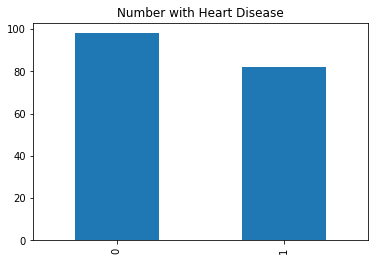

In [52]:
train_labels['class'].value_counts().plot.bar(title = 'Number with Heart Disease');

#### Criamos um [`seaborn.pairplot()`](https://seaborn.pydata.org/generated/seaborn.pairplot.html) com todos os dados, utilizando o `DataFrame` original.

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 8.34 µs


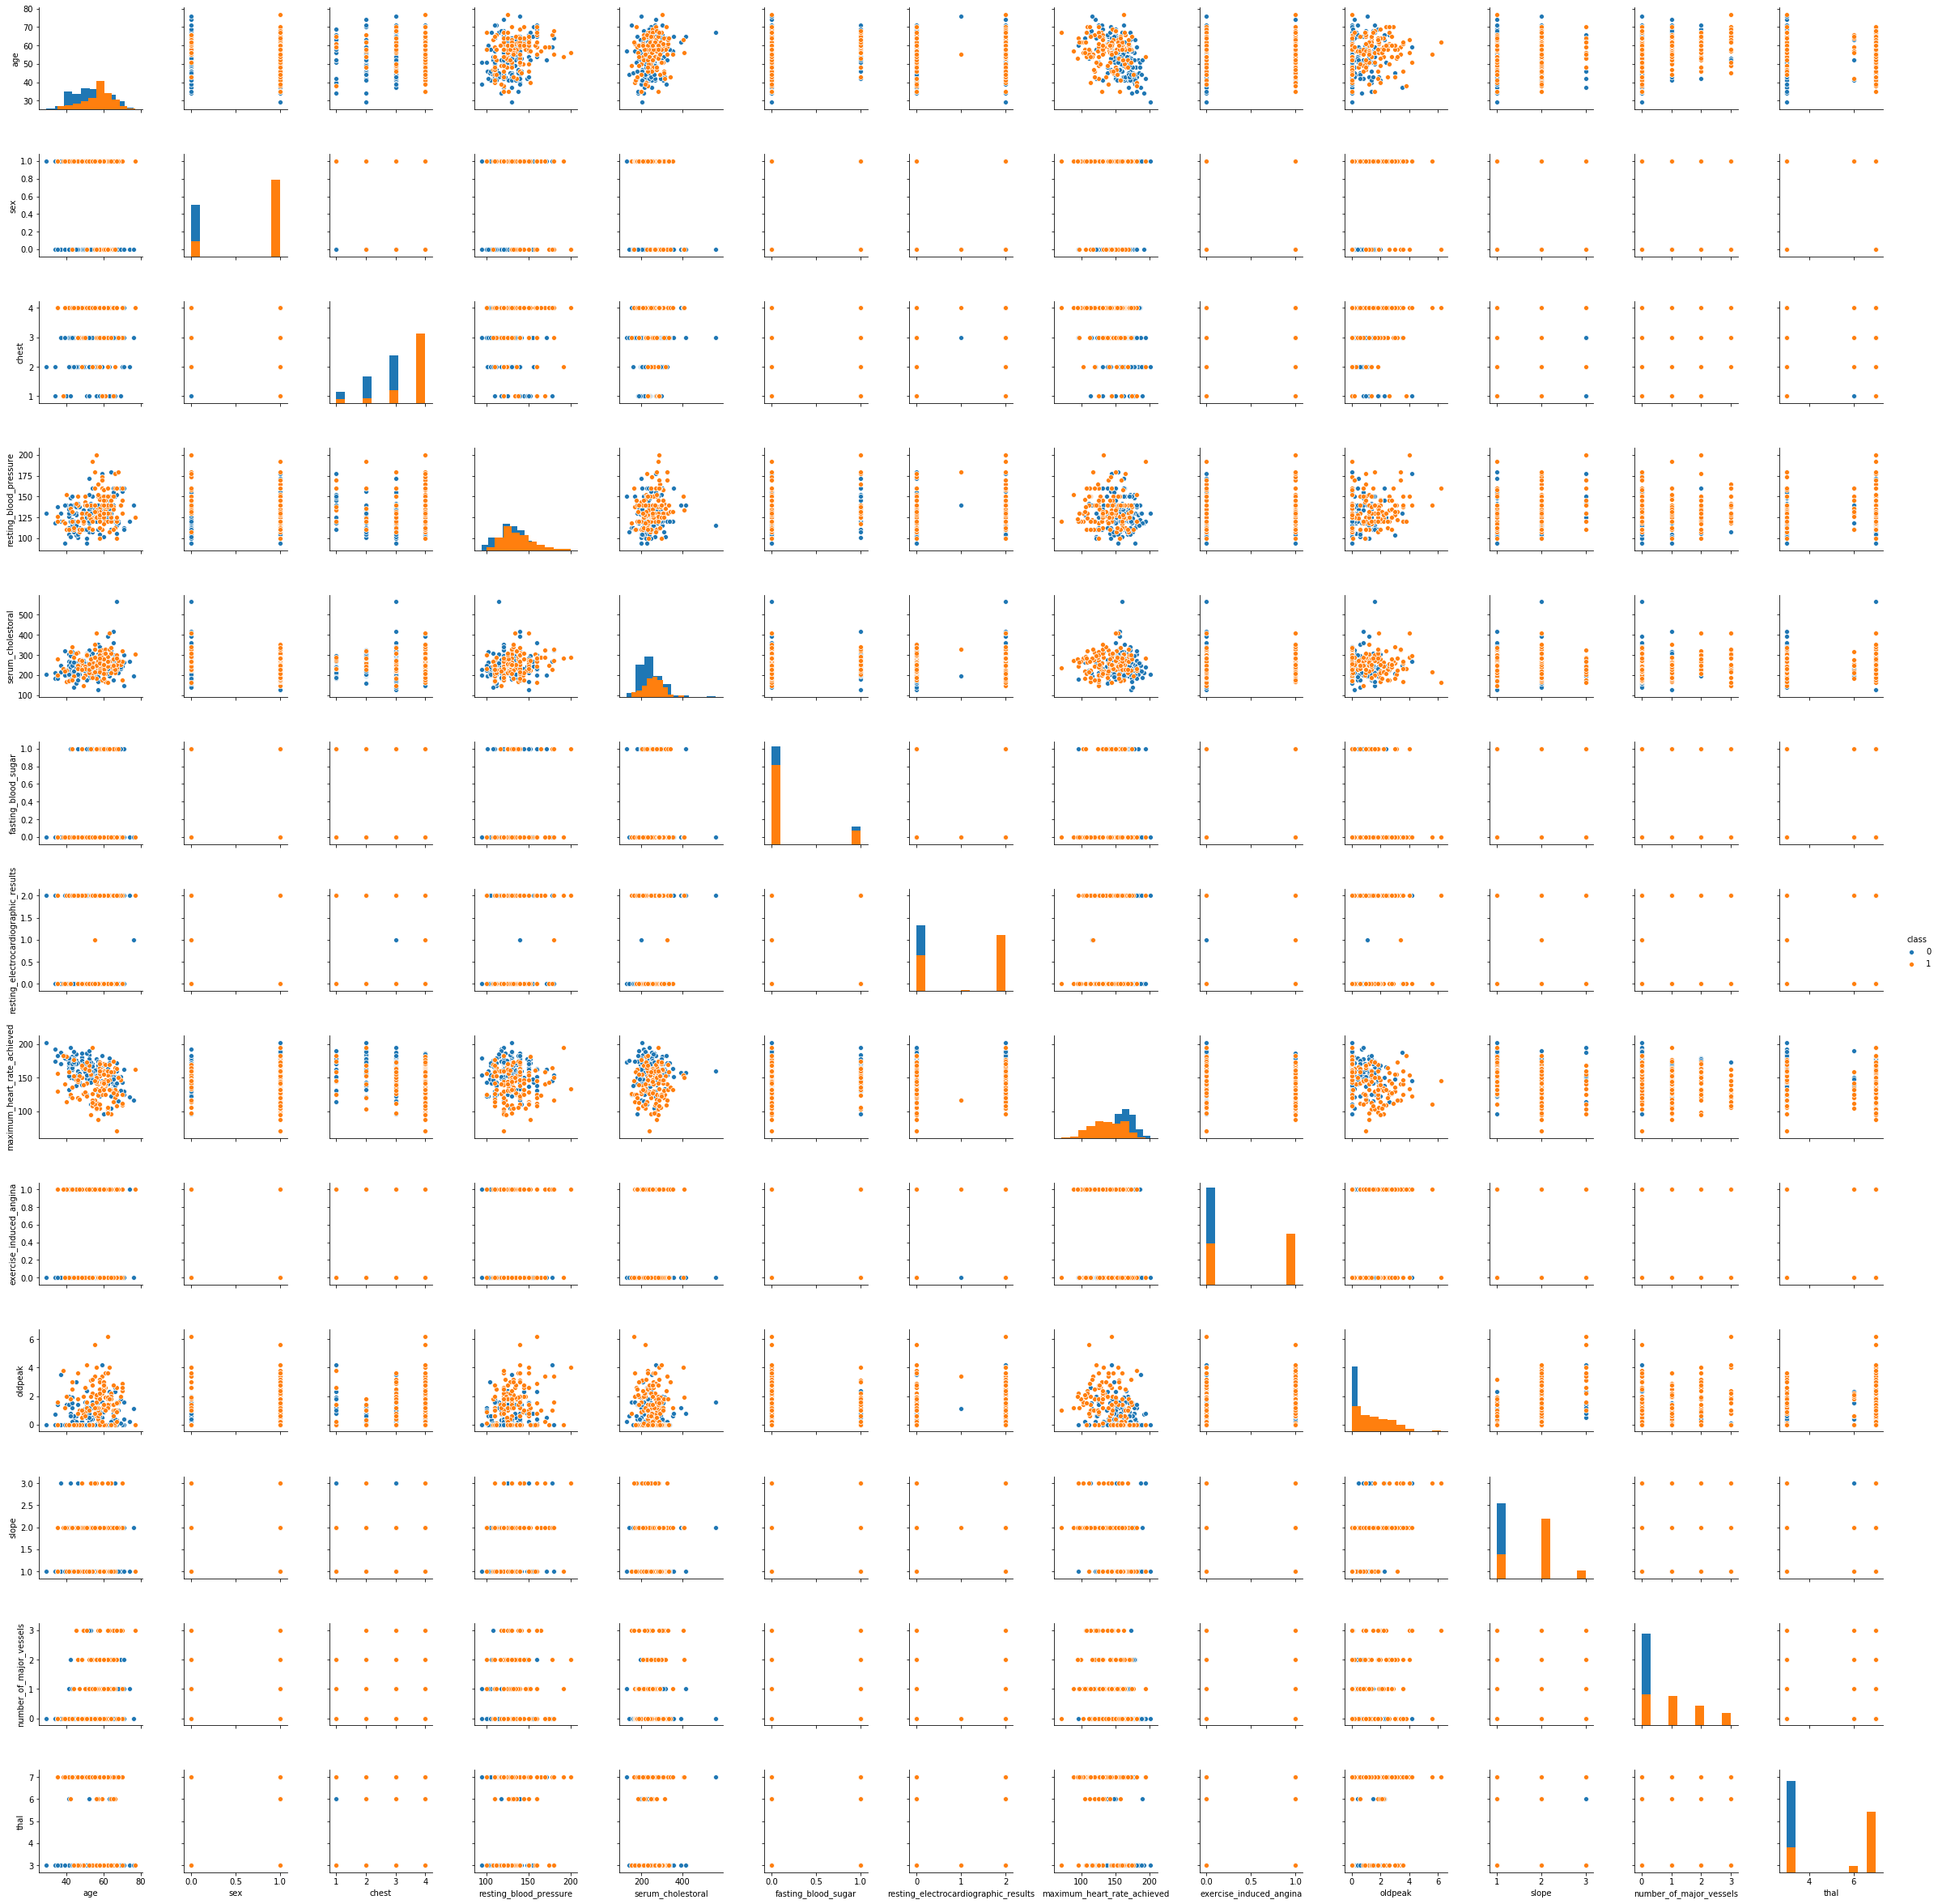

In [53]:
%time 
sns.pairplot(df,
             hue = 'class',
             diag_kind = 'hist'
            );
# Wall time: 30.9 s

#### Estatísticas descritivas básicas do `DataFrame` original.

In [54]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,270.0,54.433,9.109,29.0,48.0,55.0,61.0,77.0
sex,270.0,0.678,0.468,0.0,0.0,1.0,1.0,1.0
chest,270.0,3.174,0.950,1.0,3.0,3.0,4.0,4.0
resting_blood_pressure,270.0,131.344,17.862,94.0,120.0,130.0,140.0,200.0
serum_cholestoral,270.0,249.659,51.686,126.0,213.0,245.0,280.0,564.0
fasting_blood_sugar,270.0,0.148,0.356,0.0,0.0,0.0,0.0,1.0
resting_electrocardiographic_results,270.0,1.022,0.998,0.0,0.0,2.0,2.0,2.0
maximum_heart_rate_achieved,270.0,149.678,23.166,71.0,133.0,153.5,166.0,202.0
exercise_induced_angina,270.0,0.330,0.471,0.0,0.0,0.0,1.0,1.0
oldpeak,270.0,1.050,1.145,0.0,0.0,0.8,1.6,6.2


#### Plotando o [`heatmap()`](https://seaborn.pydata.org/generated/seaborn.heatmap.html) de correlação.

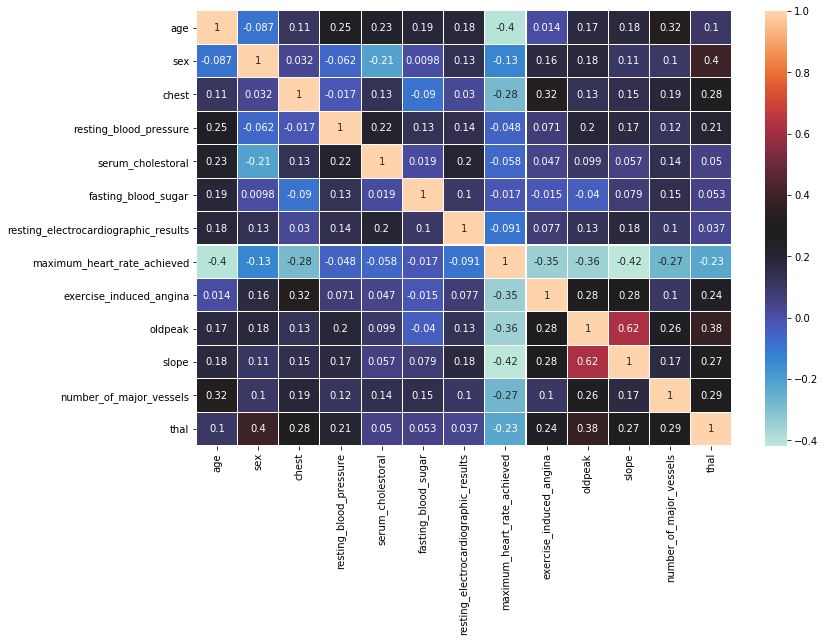

In [55]:
sns.heatmap(train.corr(method = 'pearson'), 
            annot = True, 
            cmap = 'icefire', 
            linewidths = 0.1
           )
fig = plt.gcf()
fig.set_size_inches(12,8)
plt.show()

#### Verificamos a assimetria dos dados de treino em um determinado eixo do objeto com o método [`pandas.DataFrame.skew()`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.skew.html), que calcula a assimetria dos dados presentes:

    - Se a assimetria estiver entre $-0,5$ e $0,5$, os dados são bastante simétricos;
    - Se a assimetria estiver entre $-1$ e $-0,5$ ou entre $0,5$ e $1$, os dados estão moderadamente inclinados;
    - Se a assimetria for menor que $-1$ ou maior que $1$, os dados estão altamente enviesados.

In [58]:
train.skew()

age                                    -0.118
sex                                    -0.660
chest                                  -0.894
resting_blood_pressure                  0.855
serum_cholestoral                       1.587
fasting_blood_sugar                     1.977
resting_electrocardiographic_results   -0.045
maximum_heart_rate_achieved            -0.543
exercise_induced_angina                 0.634
oldpeak                                 1.246
slope                                   0.532
number_of_major_vessels                 1.156
thal                                    0.420
dtype: float64

#### Checamos também os valores nulos de treino.

In [59]:
train.isnull().sum()

age                                     0
sex                                     0
chest                                   0
resting_blood_pressure                  0
serum_cholestoral                       0
fasting_blood_sugar                     0
resting_electrocardiographic_results    0
maximum_heart_rate_achieved             0
exercise_induced_angina                 0
oldpeak                                 0
slope                                   0
number_of_major_vessels                 0
thal                                    0
dtype: int64

#### E checamos os valores nulos de teste.

In [60]:
test.isnull().sum()

age                                     0
sex                                     0
chest                                   0
resting_blood_pressure                  0
serum_cholestoral                       0
fasting_blood_sugar                     0
resting_electrocardiographic_results    0
maximum_heart_rate_achieved             0
exercise_induced_angina                 0
oldpeak                                 0
slope                                   0
number_of_major_vessels                 0
thal                                    0
dtype: int64

#### Instanciamos um objeto para receber o modelo [`XGBoost` ](https://xgboost.readthedocs.io/en/latest/index.html) e aplicamos o método [`plot_importance()`](https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.plot_importance) para compreender a importância das colunas, com base nas árvores ajustadas.

[20:19:10] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


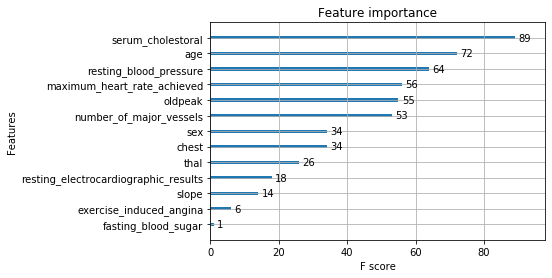

In [64]:
from xgboost import plot_importance
model = xgb.XGBClassifier()
model.fit(train, train_labels['class'].values)

# plot feature importance
plot_importance(model)
plt.show()

## Feature Engineering

#### Realizamos a "dummização" dos dados de treino e teste e em seguinda aplicamos o método [`pandas.DataFrame.align()`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.align.html#pandas-dataframe-align), que alinha dois objetos em seus eixos com o método de junção especificado.

In [70]:
one_hot_encoded_training_predictors = pd.get_dummies(train)
one_hot_encoded_test_predictors = pd.get_dummies(test)

train,test = one_hot_encoded_training_predictors.align(one_hot_encoded_test_predictors, 
                                                       join = 'left', 
                                                       axis = 1
                                                      )    

## Rodando o modelo preditor em XGBoost

#### Aplicamos um classificador [`XGBC`](https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/) e realizamos algumas predições.

In [182]:
from numpy import sort
from sklearn.feature_selection import SelectFromModel

# spliting daoa
X_train, X_test, y_train, y_test = train_test_split(train, 
                                                    train_labels['class'].values, 
                                                    test_size = 0.10, 
                                                    random_state = 7
                                                   )
# fit model on all training data
model = xgb.XGBClassifier() 
model.fit(X_train, y_train)

# make predictions for test data and evaluate
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(y_test, predictions)
#print("Accuracy: %.2f%%" % (accuracy * 100.0))

# Fit model using each importance as a threshold
thresholds = sort(model.feature_importances_)
for thresh in thresholds:
    # select features using threshold
    selection = SelectFromModel(model, 
                                threshold = thresh, 
                                prefit = True
                               )
    select_X_train = selection.transform(X_train)

    # train model
    selection_model = xgb.XGBClassifier()
    selection_model.fit(select_X_train, y_train)

    # eval model
    select_X_test = selection.transform(X_test)
    y_pred = selection_model.predict(select_X_test)
    predictions = [round(value) for value in y_pred]
    accuracy = accuracy_score(y_test, predictions)
#    print("Thresh=%.3f, n=%d, Accuracy: %.2f%%" % (thresh, select_X_train.shape[1], accuracy * 100.0))

[20:53:20] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:53:20] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/rudineycasali/opt/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/rudineycasali/opt/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:53:20] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:53:20] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/rudineycasali/opt/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/rudineycasali/opt/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:53:21] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:53:21] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/rudineycasali/opt/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/rudineycasali/opt/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:53:21] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:53:21] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/rudineycasali/opt/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/rudineycasali/opt/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:53:21] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:53:21] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/rudineycasali/opt/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/rudineycasali/opt/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:53:21] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:53:22] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/rudineycasali/opt/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/rudineycasali/opt/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:53:22] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:53:22] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/rudineycasali/opt/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


In [183]:
#train_df = train

## Verificando a performance do modelo para diferente número de estimadores

#### Separamos nossos dados em treino e teste.

In [73]:
train_X, test_X, train_Y, test_Y = train_test_split(train, 
                                                    train_labels, 
                                                    test_size = 0.10, 
                                                    stratify = train_labels, 
                                                    random_state = 42
                                                   )
# checking results
print(train_X.shape, test_X.shape)
print()
print('Number of rows in Train dataset:',train_X.shape[0])
print()
print('Number of rows in Test dataset:',test_X.shape[0])

(162, 13) (18, 13)

Number of rows in Train dataset: 162

Number of rows in Test dataset: 18


#### Reescalonamos nossos dados.

In [74]:
scaler = StandardScaler()
train_X = scaler.fit_transform(train_X)
test_X = scaler.transform(test_X)

#### Instalamos os pacotes de [`GridSearchCV`](https://mlfromscratch.com/gridsearch-keras-sklearn/#/) para faze a busca pela melhor combinação de parâmetros e [`StratifiedKFold`](https://machinelearningmastery.com/evaluate-gradient-boosting-models-xgboost-python/) para estabelecer uma estratégia de validação cruzada e 


$$
\text{Log Loss} = -\frac{1}{N}\sum_{i = 1}^{N}[y_{i}\log{p_{i}} + (1 - y_{i})\log{(1 - p_{i})}]
$$

#### Depois plotamos a curva [`Log Loss`](https://medium.datadriveninvestor.com/understanding-the-log-loss-function-of-xgboost-8842e99d975d) versus `n_estimators`.

/Users/rudineycasali/opt/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:32:05] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Result: -0.489238 (0.212663) with param: {'n_estimators': 50}
Result: -0.508482 (0.251458) with param: {'n_estimators': 100}
Result: -0.519824 (0.266200) with param: {'n_estimators': 150}
Result: -0.526179 (0.276898) with param: {'n_estimators': 200}
Result: -0.531087 (0.284295) with param: {'n_estimators': 250}
Result: -0.534890 (0.292494) with param: {'n_estimators': 300}
Result: -0.538295 (0.297998) with param: {'n_estimators': 350}
Result: -0.542247 (0.301846) with param: {'n_estimators': 400}
Result: -0.545503 (0.307207) with param: {'n_estimators': 450}
Result: -0.548456 (0.310507) with param: {'n_estimators': 500}
Result: -0.551266 (0.314588) with param: {'n_estimators': 550}
Result: -0.554691 (0.31805

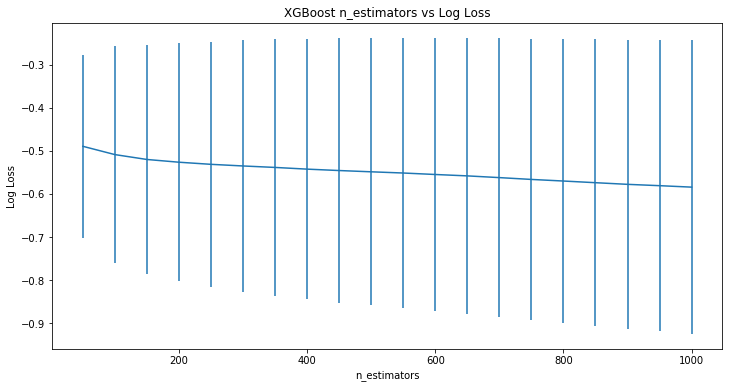

In [77]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

# running model with grid search
model = xgb.XGBClassifier()
n_estimators = range(50, 1050, 50)
param_grid = dict(n_estimators = n_estimators)

kfold = StratifiedKFold(n_splits = 10, 
                        shuffle = True, 
                        random_state = 7
                       )
grid_search = GridSearchCV(model, 
                           param_grid, 
                           scoring = "neg_log_loss", 
                           n_jobs = -1, 
                           cv = kfold
                          )
grid_result = grid_search.fit(train_X, train_Y.values.ravel())

# summarize results
#print("Best result: %f with param %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
    print("Result: %f (%f) with param: %r" % (mean, stdev, param))

# plot
fig = plt.figure(figsize = (12, 6))
plt.errorbar(n_estimators, means, yerr = stds )
plt.title("XGBoost n_estimators vs Log Loss")
plt.xlabel('n_estimators')
plt.ylabel('Log Loss')
plt.savefig('n_estimators.png')

#### Aplicamos o método de [`GridSearchCV`](https://www.mikulskibartosz.name/xgboost-hyperparameter-tuning-in-python-using-grid-search/) para otimizar os hiper-parâmetros.

range(1, 21, 2)


/Users/rudineycasali/opt/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:48:22] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
-0.435194 (0.173783) with: {'max_depth': 1}
-0.513830 (0.280120) with: {'max_depth': 3}
-0.501356 (0.255343) with: {'max_depth': 5}
-0.504161 (0.255332) with: {'max_depth': 7}
-0.504161 (0.255332) with: {'max_depth': 9}
-0.504161 (0.255332) with: {'max_depth': 11}
-0.504161 (0.255332) with: {'max_depth': 13}
-0.504161 (0.255332) with: {'max_depth': 15}
-0.504161 (0.255332) with: {'max_depth': 17}
-0.504161 (0.255332) with: {'max_depth': 19}


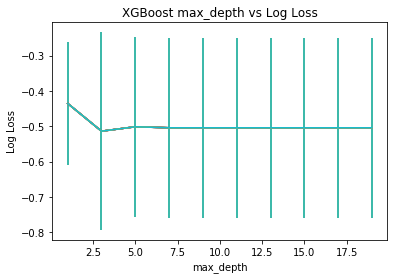

In [79]:
model = xgb.XGBClassifier()
max_depth = range(1, 21, 2)
print(max_depth)

param_grid = dict(max_depth = max_depth)

kfold = StratifiedKFold(n_splits = 10, 
                        shuffle = True, 
                        random_state = 7
                       )
grid_search = GridSearchCV(model, 
                           param_grid, 
                           scoring = "neg_log_loss", 
                           n_jobs = -1, 
                           cv  = kfold
                          )

grid_result = grid_search.fit(train_X, train_Y.values.ravel())

# summarize results
#print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
    # plot
    plt.errorbar(max_depth, means, yerr = stds)
    plt.title("XGBoost max_depth vs Log Loss")
    plt.xlabel('max_depth')
    plt.ylabel('Log Loss')
    plt.savefig('max_depth.png')

#### Istanciamos um modelo [`XGBoost`](https://machinelearningmastery.com/gentle-introduction-xgboost-applied-machine-learning/) com `n_estimators = 50` e `max_depth = 1`.

In [80]:
model_base = xgb.XGBClassifier(max_depth = 1, 
                               subsample = 0.33, 
                               objective = 'binary:logistic', 
                               n_estimators = 50, 
                               learning_rate = 0.12
                              )
eval_set = [(train_X, train_Y.values.ravel()), 
            (test_X, test_Y.values.ravel())
           ]
model_base.fit(train_X, train_Y.values.ravel(), 
               early_stopping_rounds = 15, 
               eval_metric = ["error", "logloss"], 
               eval_set = eval_set
              )

[0]	validation_0-error:0.24691	validation_0-logloss:0.66457	validation_1-error:0.16667	validation_1-logloss:0.65506
[1]	validation_0-error:0.23457	validation_0-logloss:0.63297	validation_1-error:0.27778	validation_1-logloss:0.62860
[2]	validation_0-error:0.15432	validation_0-logloss:0.60872	validation_1-error:0.11111	validation_1-logloss:0.59407
[3]	validation_0-error:0.20370	validation_0-logloss:0.58652	validation_1-error:0.22222	validation_1-logloss:0.57705
[4]	validation_0-error:0.15432	validation_0-logloss:0.57085	validation_1-error:0.16667	validation_1-logloss:0.56234
[5]	validation_0-error:0.16049	validation_0-logloss:0.55556	validation_1-error:0.16667	validation_1-logloss:0.53642
[6]	validation_0-error:0.15432	validation_0-logloss:0.54426	validation_1-error:0.11111	validation_1-logloss:0.51365
[7]	validation_0-error:0.14197	validation_0-logloss:0.53633	validation_1-error:0.16667	validation_1-logloss:0.51052
[8]	validation_0-error:0.17901	validation_0-logloss:0.53487	validation_1

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.12, max_delta_step=0, max_depth=1,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=50, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.33,
              tree_method='exact', validate_parameters=1, verbosity=None)

#### Realizamos nossas previsões com os dados de teste.

In [81]:
y_pred = model_base.predict(test_X)
predictions = [round(value) for value in y_pred]

In [84]:
#type(model_base)

#### E avaliamos nossas previsões.

In [82]:
accuracy = accuracy_score(test_Y, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 88.89%


#### Recuperamos as métricas de performance.

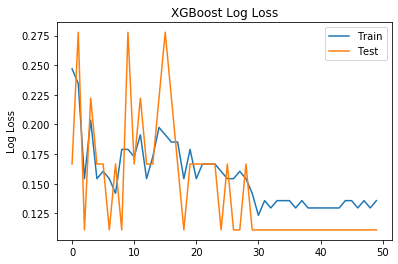

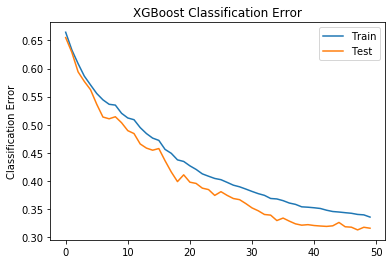

In [191]:
results = model_base.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)

# plot log loss
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['error'], 
        label = 'Train'
       )
ax.plot(x_axis, 
        results['validation_1']['error'], 
        label = 'Test'
       )
ax.legend()
plt.ylabel('Log Loss')
plt.title('XGBoost Log Loss')
plt.show()

# plot classification error
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['logloss'], 
        label = 'Train'
       )
ax.plot(x_axis, results['validation_1']['logloss'], 
        label = 'Test'
       )
ax.legend()
plt.ylabel('Classification Error')
plt.title('XGBoost Classification Error')
plt.show()